### **CONTENT-BASED FILTERING** ###

##### ***INFORMATION*** ######
- Uses movie Genres as the content feature to compare.
- Used past ratings to learn prefernces

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from fastai.vision.all import untar_data, URLs

In [2]:
# Load Data
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv(path/'u.item', sep='|', encoding='latin-1', header=None,
                     names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)])

# item_id and genre columns only
movie_genres = movies[['item_id'] + [f'genre_{i}' for i in range(19)]]

# Merge ratings with genres
data = pd.merge(ratings, movie_genres, on='item_id')


In [3]:
# Train-test split
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)


In [4]:
# Build user profiles based on genre preference

user_profiles = {}

for user_id in train_df['user_id'].unique():

    user_data = train_df[train_df['user_id'] == user_id]
    genre_matrix = user_data[[f'genre_{i}' for i in range(19)]].values
    ratings_vector = user_data['rating'].values.reshape(-1, 1)

    # Weighted average of genres by user ratings
    user_profile = np.sum(genre_matrix * ratings_vector, axis=0)
    user_profiles[user_id] = user_profile

In [5]:
# Predict ratings

def predict_rating(user_id, item_id):

    # If unknown user or item, return global average
    if user_id not in user_profiles or item_id not in movie_genres['item_id'].values:
        return train_df['rating'].mean()

    user_profile = user_profiles[user_id]
    item_vector = movie_genres[movie_genres['item_id'] == item_id].iloc[0][1:].values.astype(float)

    # Cosine similarity between user profile and item genre vector
    norm_user = np.linalg.norm(user_profile)
    norm_item = np.linalg.norm(item_vector)

    if norm_user == 0 or norm_item == 0:
        return train_df['rating'].mean()

    similarity = np.dot(user_profile, item_vector) / (norm_user * norm_item)

    # Scale similarity to rating scale [1, 5]
    predicted_rating = similarity * 5
    return min(max(predicted_rating, 1), 5)


In [6]:
# Evaluate test set

true_ratings = []
pred_ratings = []

for _, row in test_df.iterrows():
    user = row['user_id']
    item = row['item_id']
    true = row['rating']
    pred = predict_rating(user, item)

    true_ratings.append(true)
    pred_ratings.append(pred)

# Step 7: Error metrics
mae = mean_absolute_error(true_ratings, pred_ratings)
rmse = sqrt(mean_squared_error(true_ratings, pred_ratings))

print("Content-Based Filtering Results:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Content-Based Filtering Results:
MAE: 1.4220
RMSE: 1.7248


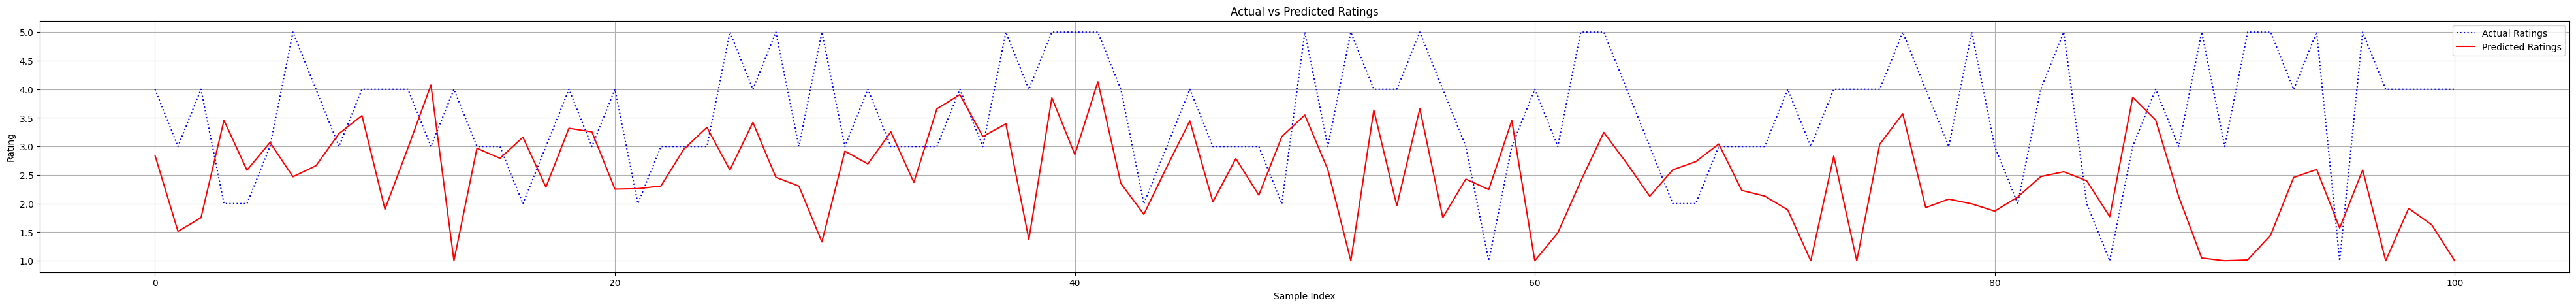

In [8]:
# Analyze Graphically

plt.figure(figsize=(50, 5))
plt.plot(true_ratings[0:101], label='Actual Ratings', linestyle='dotted', color='blue')
plt.plot(pred_ratings[0:101], label='Predicted Ratings' , linestyle='solid', color='red')
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.show()